## Generation Expansion Planning (GEP) Explicit Formulation

### Indices

| **Name** | **Description**                   |
|----------|-----------------------------------|
| $p$      | time periods                      |
| $g$      | generation technologies           |
| $r(g)$   | subset of renewable techonologies |
| $sc$     | scenarios                         |

### Parameters

| **Name**   | **Domains** | **Description**                                             |
|------------|-------------|-------------------------------------------------------------|
| $pVOLL   $ |             | Value of Lost Load [\$/MWh]                                 |
| $pWeight $ |             | Representative period weight [hours]                        |
| $pInvCost$ | $g$         | Investment cost [\$/MW]                                     |
| $pVarCost$ | $g$         | Variable production cost [\$/MWh]                           |
| $pUnitCap$ | $g$         | Capacity per each invested unit [MW/unit]                   |
| $pRenProf$ | $r,p,sc$    | Renewable profile (e.g., load factor) [p.u.]                |
| $pDemand $ | $p$         | Demand [MW]                                                 |
| $pScProb $ | $sc$        | Scenario probability [p.u.]                                 |

### Variables

| **Name**    | **Domains** | **Description**              |
|-------------|-------------|------------------------------|
| $vTotCost $ |             | Total system cost [\$]       |
| $vInvCost $ |             | Total investment cost [\$]   |
| $vOpeCost $ |             | Total operating cost [\$]    |
| $vGenInv  $ | $g,sc$      | Generation investment [1..N] |
| $vGenProd $ | $g,p,sc$    | Generation production [MW]   |
| $vLossLoad$ | $p,sc$      | Loss of load [MW]            |

### Equations

| **Name**    | **Domains** | **Description**                    |
|-------------|-------------|------------------------------------|
| $eObjFun $  |             | Total system cost [\$]             |
| $eInvCost$  |             | Total investment cost [\$]         |
| $eOpeCost$  |             | Total operating cost [\$]          |
| $eBalance$  | $p,sc$      | Power system balance [MWh]         |
| $eMaxProd$  | $g,p,sc$    | Maximum generation production [MW] |
| $eRenProd$  | $r,p,sc$    | Maximum renewable production [MW]  |
| $eInvNAC $  | $g,sc$      | Nonanticipativity constraints [MW] |

#### *eObjFun*

$$
\displaystyle{\min{vTotCost = vInvCost + vOpeCost}}
$$

#### *eInvCost*

$$
vInvCost = \displaystyle \sum_{g}\sum_{sc}pScProb_{sc} \cdot (pInvCost_{g} \cdot pUnitCap_{g} \cdot vGenInv_{g,sc})
$$

#### *eOpeCost*

$$
vOpeCost = pWeight \cdot {\left(\displaystyle \sum_{sc}pScProb_{sc}\cdot{\left(\sum_{g,p}pVarCost_{g} \cdot vGenProd_{g,p,sc} + \sum_{p,sc}pVOLL \cdot vLossLoad_{p,sc}\right)}\right)}
$$

#### *eBalance*

$$
\displaystyle \sum_{g}vGenProd_{g,p,sc} + vLossLoad_{p,sc} = pDemand_{p} \quad \forall{p,sc}
$$

#### *eMaxProd*

$$
vGenProd_{g,p,sc} \leq pUnitCap_{g} \cdot vGenInv_{g,sc} \quad \forall{g,p,sc}
$$

#### *eRenProd*

$$
vGenProd_{r,p,sc} \leq pRenProf_{r,p,sc} \cdot pUnitCap_{r} \cdot vGenInv_{r,sc} \quad \forall{r,p,sc}
$$

#### *eInvNAC*

$$
vGenInv_{g,sc} = vGenInv_{g,sc-1} \quad \forall{g,sc | sc > 1}
$$

#### *Bounds*

$vGenProd_{g,p,sc}\geq 0 ~ \forall g, p, sc $

$vLossLoad_{p,sc}\geq 0 ~ \forall p, sc $

$vGenInv_{g,sc} \in \mathbb{Z}^{+} ~ \forall g, sc $

In [1]:
# Packages
using JuMP
using HiGHS
using CSV
using DataFrames
using Plots
using StatsPlots

In [2]:
# include the helper functions
include("functions-to-import-data.jl");
include("functions-to-export-data.jl");
include("functions-to-plot-results.jl");

In [3]:
# include the file with the functions for the stochastic GEP model
include("Stochastic-GEP-two-stage.jl");

In [4]:
# Folders names
input_folder = joinpath(@__DIR__, "inputs/two-stage-3sc");
output_folder = joinpath(@__DIR__, "outputs/two-stage-3sc");

In [5]:
# read the data
sets, params = read_two_stage_data(input_folder);

In [6]:
model = create_and_solve_model_explicit_formulation(sets, params)

Running HiGHS 1.10.0 (git hash: fd8665394e): Copyright (c) 2025 HiGHS under MIT licence terms
MIP  has 368 rows; 372 cols; 916 nonzeros; 12 integer variables (0 binary)
Coefficient ranges:
  Matrix [1e-01, 4e+02]
  Cost   [7e-02, 8e+03]
  Bound  [8e+02, 1e+03]
  RHS    [8e+02, 1e+03]
Presolving model
324 rows, 328 cols, 828 nonzeros  0s
324 rows, 328 cols, 828 nonzeros  0s

Solving MIP model with:
   324 rows
   328 cols (0 binary, 4 integer, 0 implied int., 324 continuous)
   828 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; H => Heuristic; L => Sub-MIP;
     P => Empty MIP; R => Randomized rounding; S => Solve LP; T => Evaluate node; U => Unbounded;
     z => Trivial zero; l => Trivial lower; u => Trivial upper; p => Trivial point; X => User solution

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
Src  Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |  

A JuMP Model
├ solver: HiGHS
├ objective_sense: MIN_SENSE
│ └ objective_function_type: AffExpr
├ num_variables: 372
├ num_constraints: 824
│ ├ AffExpr in MOI.EqualTo{Float64}: 80
│ ├ AffExpr in MOI.LessThan{Float64}: 288
│ ├ VariableRef in MOI.GreaterThan{Float64}: 372
│ ├ VariableRef in MOI.LessThan{Float64}: 72
│ └ VariableRef in MOI.Integer: 12
└ Names registered in the model
  └ :c_balance, :c_max_prod, :c_non_antic, :v_ens, :v_investment, :v_production

In [7]:
write_to_file(model, "explicit_model.lp")

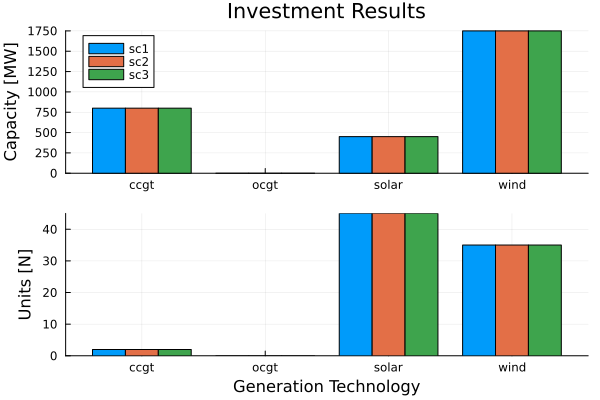

In [8]:
plot_two_stage_investment_explicit_formulation(model, sets, params)

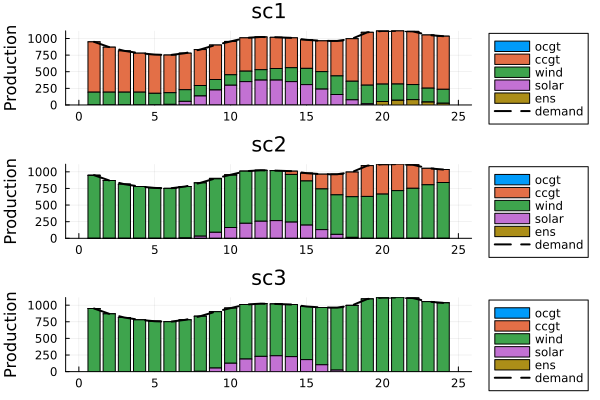

In [9]:
plot_two_stage_production(model, params)

In [10]:
save_two_stage_explicit_formulation_results_to_csv(output_folder, model)